In [2]:
import pandas as pd
from bert_score import score
import torch
import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import re
from tqdm.notebook import tqdm

tqdm.pandas()

/root/.pyenv/versions/3.12.2/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
from evaluate import load

bertscore = load("bertscore")

/root/.pyenv/versions/3.12.2/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/root/.pyenv/versions/3.12.2/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/root/.pyenv/versions/3.12.2/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
df = pd.read_csv('text_sum_stats.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26921 entries, 0 to 26920
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                26921 non-null  object
 1   raw_product         25730 non-null  object
 2   product             14400 non-null  object
 3   raw_locations       26921 non-null  object
 4   locations           26921 non-null  object
 5   news_date           26921 non-null  int64 
 6   url                 26921 non-null  object
 7   summary             26921 non-null  object
 8   lang                26921 non-null  object
 9   text_words          26921 non-null  object
 10  summary_words       26921 non-null  object
 11  text_lemmas         26921 non-null  object
 12  summary_lemmas      26921 non-null  object
 13  product_lemmas      26921 non-null  object
 14  country_lemmas      26921 non-null  object
 15  num_summary_sents   26921 non-null  int64 
 16  text_len            26

In [6]:
df = df[['text', 'summary', 'lang', 'news_date']]

In [7]:
# df.to_csv('summary_all_data.csv', index=False)

In [8]:
df = df[['text', 'summary']]

In [9]:
# df.to_csv('text_sum.csv', index=False)

In [10]:
df = df.dropna(subset='text')

In [11]:
device = torch.device('cuda:1')

In [12]:
path_to_model = f"./model"
model = AutoModelForSeq2SeqLM.from_pretrained(path_to_model)
tokenizer = AutoTokenizer.from_pretrained(path_to_model)
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [13]:
def infer(text):
    WHITESPACE_HANDLER = lambda k: re.sub("\s+", " ", re.sub("\n+", " ", k.strip()))

    input_ids = tokenizer(
        [WHITESPACE_HANDLER(text)],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512,
    )["input_ids"].to(device)

    output_ids = model.generate(
        input_ids=input_ids, max_length=200, no_repeat_ngram_size=2, num_beams=4
    )[0]

    summary = tokenizer.decode(
        output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return summary


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_573682/2290899452.py:2: SyntaxWarning: invalid escape sequence '\s'
  WHITESPACE_HANDLER = lambda k: re.sub("\s+", " ", re.sub("\n+", " ", k.strip()))


In [14]:
df.text[0]

'На фоне истощения запасов вооружения в западных странах в Киеве растет беспокойство по поводу способности союзников поддерживать темпы поставок оружия. Об этом 22 ноября сообщает газета Le Monde. «Запасы боеприпасов в западных арсеналах истощаются чрезвычайно быстро. Отныне страны должны использовать свои критические запасы, если они хотят поддержать Украину», — приводит газета заявление постоянного секретаря министерства обороны Эстонии Кусти Салма. Отмечается, что страны — поставщики оружия сами теперь нуждаются в срочном пополнении запасов вооружения. За месяцы боевых действий Запад широко раскрыл свои арсеналы, в первую очередь США, которые обеспечивают две трети военной помощи. Пентагон официально поставил Киеву более миллиона снарядов с 24 февраля: 924 тыс. калибра 155 мм, 125 тыс. — 120 мм, 180 тыс. — 105 мм. Ранее в этот день министр обороны Германии Кристина Ламбрехт заявила, что вооруженным силам страны сложно откликаться на просьбы третьих стран об оказании военной помощи. 

In [15]:
infer(df.text[0])

/root/.pyenv/versions/3.12.2/lib/python3.12/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


'На фоне истощения запасов вооружения в западных странах в Киеве растет беспокойство по поводу способности союзников поддерживать темпы поставок оружия.'

In [17]:
# df['simle_sum'] = df.text.progress_apply(infer)

In [ ]:
df.to_csv('text_sum_smallsum_metrics.csv', index=False)

In [ ]:
df

,text,summary,simle_sum
0,На фоне истощения запасов вооружения в западны...,На фоне истощения запасов вооружения в западны...,На фоне истощения запасов вооружения в западны...
1,"ДОХА, 21 ноя —ПРАЙМ. Катарская национальная не...",Катарская национальная нефтегазовая компания Q...,Катарская национальная нефтегазовая компания Q...
2,Россия обсудит с ОНН вопрос о возобновлении по...,Россия обсудит с ООН вопрос о возобновлении по...,Россия обсудит с ООН вопрос о возобновлении по...
3,"Евгений Томихин указал, что эта тема обсуждает...",Посол РФ выразил надежду на подвижки в вопросе...,Россия рассчитывает на продвижение в вопросе и...
4,"МОСКВА, 23 ноя — ПРАЙМ. Индонезии требуются ин...",Индонезии требуются инвестиции в размере 179 м...,Индонезии требуются инвестиции в размере 179 м...
...,...,...,...
26916,"МОСКВА, 29 ноября. /ТАСС/. Компания Uranium On...",29 ноября 2021 года компания Uranium One Holdi...,Компания Uranium One Holding N. V. (предприяти...
26917,«Российские и индийские специалисты провели бо...,Россия и Индия подписали контракт о совместном...,«Российские и индийские специалисты провели бо...
26918,"МОСКВА, 6 дек — ПРАЙМ. Совместное российско-ин...",Совместное российско-индийское предприятие в и...,Совместное российско-индийское предприятие в и...
26919,"НЬЮ-ДЕЛИ, 6 декабря. /ТАСС/. Индия приложит ус...",Индия приложит усилия для официального выделен...,Индия приложит усилия для официального выделен...


In [18]:
df = pd.read_csv('text_sum_smallsum.csv')

In [19]:
df

,text,summary,simle_sum
0,На фоне истощения запасов вооружения в западны...,На фоне истощения запасов вооружения в западны...,На фоне истощения запасов вооружения в западны...
1,"ДОХА, 21 ноя —ПРАЙМ. Катарская национальная не...",Катарская национальная нефтегазовая компания Q...,Катарская национальная нефтегазовая компания Q...
2,Россия обсудит с ОНН вопрос о возобновлении по...,Россия обсудит с ООН вопрос о возобновлении по...,Россия обсудит с ООН вопрос о возобновлении по...
3,"Евгений Томихин указал, что эта тема обсуждает...",Посол РФ выразил надежду на подвижки в вопросе...,Россия рассчитывает на продвижение в вопросе и...
4,"МОСКВА, 23 ноя — ПРАЙМ. Индонезии требуются ин...",Индонезии требуются инвестиции в размере 179 м...,Индонезии требуются инвестиции в размере 179 м...
...,...,...,...
26916,"МОСКВА, 29 ноября. /ТАСС/. Компания Uranium On...",29 ноября 2021 года компания Uranium One Holdi...,Компания Uranium One Holding N. V. (предприяти...
26917,«Российские и индийские специалисты провели бо...,Россия и Индия подписали контракт о совместном...,«Российские и индийские специалисты провели бо...
26918,"МОСКВА, 6 дек — ПРАЙМ. Совместное российско-ин...",Совместное российско-индийское предприятие в и...,Совместное российско-индийское предприятие в и...
26919,"НЬЮ-ДЕЛИ, 6 декабря. /ТАСС/. Индия приложит ус...",Индия приложит усилия для официального выделен...,Индия приложит усилия для официального выделен...


In [20]:
precision_scores = []
recall_scores = []
f1_scores = []

In [21]:
for text, summary in tq.tqdm(zip(df["text"], df["summary"])):
    results = bertscore.compute(
        predictions=[summary],
        references=[text],
        model_type="bert-base-multilingual-cased",
        device=device,
    )
    precision_scores.append(results["precision"][0])
    recall_scores.append(results["recall"][0])
    f1_scores.append(results["f1"][0])

0it [00:00, ?it/s]/root/.pyenv/versions/3.12.2/lib/python3.12/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
26921it [16:53, 26.57it/s]


In [22]:
df["precision_manual"] = precision_scores
df["recall_manual"] = recall_scores
df["f1_manual"] = f1_scores

In [23]:
precision_scores2 = []
recall_scores2 = []
f1_scores2 = []

In [24]:
for text, summary in tq.tqdm(zip(df["text"], df["simle_sum"])):
    results = bertscore.compute(
        predictions=[summary],
        references=[text],
        model_type="bert-base-multilingual-cased",
        device=device,
    )
    precision_scores2.append(results["precision"][0])
    recall_scores2.append(results["recall"][0])
    f1_scores2.append(results["f1"][0])

26921it [16:34, 27.06it/s]


In [25]:
df["precision_mt5"] = precision_scores2
df["recall_mt5"] = recall_scores2
df["f1_mt5"] = f1_scores2

In [26]:
precision_scores3 = []
recall_scores3 = []
f1_scores3 = []

In [27]:
for text, summary in tq.tqdm(zip(df["text"], df["simle_sum"][::-1])):
    results = bertscore.compute(
        predictions=[summary],
        references=[text],
        model_type="bert-base-multilingual-cased",
        device=device,
    )
    precision_scores3.append(results["precision"][0])
    recall_scores3.append(results["recall"][0])
    f1_scores3.append(results["f1"][0])

26921it [16:39, 26.94it/s]


In [28]:
df["precision_random"] = precision_scores3
df["recall_random"] = recall_scores3
df["f1_random"] = f1_scores3

In [29]:
print(f"Bert-score precision саммари - ручная разметка {df['precision_manual'].mean() :.3f}")
print(f"Bert-score precision саммари - модель mT5_multilingual_XLSum {df['precision_mt5'].mean():.3f}")

Bert-score precision саммари - ручная разметка 0.856
Bert-score precision саммари - модель mT5_multilingual_XLSum 0.848


In [30]:
print(f"Bert-score recall саммари - ручная разметка {df['recall_manual'].mean() :.3f}")
print(f"Bert-score recall саммари - модель mT5_multilingual_XLSum {df['recall_mt5'].mean():.3f}")

Bert-score recall саммари - ручная разметка 0.685
Bert-score recall саммари - модель mT5_multilingual_XLSum 0.629


In [31]:
print(f"Bert-score f1 саммари - ручная разметка {df['f1_manual'].mean() :.3f}")
print(f"Bert-score f1 саммари - модель mT5_multilingual_XLSum {df['f1_mt5'].mean():.3f}")

Bert-score f1 саммари - ручная разметка 0.760
Bert-score f1 саммари - модель mT5_multilingual_XLSum 0.722


In [32]:
metrics_manual = {'precision': df['precision_manual'].mean(), 'recall': df['recall_manual'].mean(), 'f1': df['f1_manual'].mean(), 'std_precision': df['precision_manual'].std(), 'std_recall': df['recall_manual'].std(), 'std_f1': df['f1_manual'].std()}
metrics_mT5 = {'precision': df['precision_mt5'].mean(), 'recall': df['recall_mt5'].mean(), 'f1': df['f1_mt5'].mean(), 'std_precision': df['precision_mt5'].std(), 'std_recall': df['recall_mt5'].std(), 'std_f1': df['f1_mt5'].std()}
metrics_random = {'precision': df['precision_random'].mean(), 'recall': df['recall_random'].mean(), 'f1': df['f1_random'].mean(), 'std_precision': df['precision_random'].std(), 'std_recall': df['recall_random'].std(), 'std_f1': df['f1_random'].std()}
# std_manual = {'std_precision': df['precision_manual'].std(), 'std_recall': df['recall_manual'].std(), 'std_f1': df['f1_manual'].std()}
# std_metrics_mT5 = {'std_precision': df['precision_mt5'].std(), 'std_recall': df['recall_mt5'].std(), 'std_f1': df['f1_mt5'].std()}

data = pd.DataFrame({
    'manual': pd.Series(metrics_manual),
    'mT5_multilingual_XLSum': pd.Series(metrics_mT5),
    'random': pd.Series(metrics_random)
})
data

,manual,mT5_multilingual_XLSum,random
precision,0.855738,0.848048,0.630689
recall,0.685404,0.628855,0.547413
f1,0.759816,0.721564,0.585786
std_precision,0.052763,0.031111,0.030102
std_recall,0.081000,0.048699,0.028576
std_f1,0.065605,0.039727,0.026016


In [33]:
# data.to_csv('metrics.csv')

In [34]:
# df.to_excel('sum_metrics.xlsx')

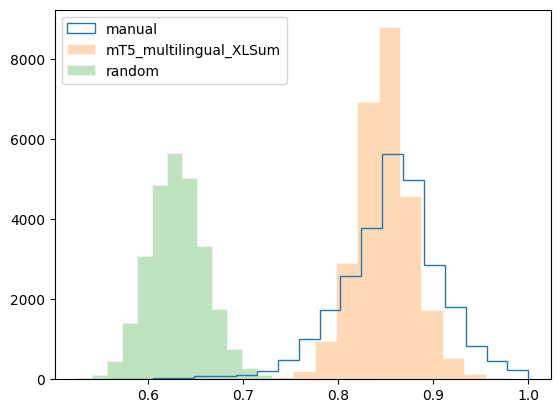

In [35]:
plt.hist(df.precision_manual, bins=20, histtype="step", label="manual")
plt.hist(df.precision_mt5, bins=20, histtype="stepfilled", label="mT5_multilingual_XLSum", alpha=0.3, edgecolor="w")
plt.hist(df.precision_random, bins=20, histtype="stepfilled", label="random", alpha=0.3, edgecolor="w")
plt.legend();

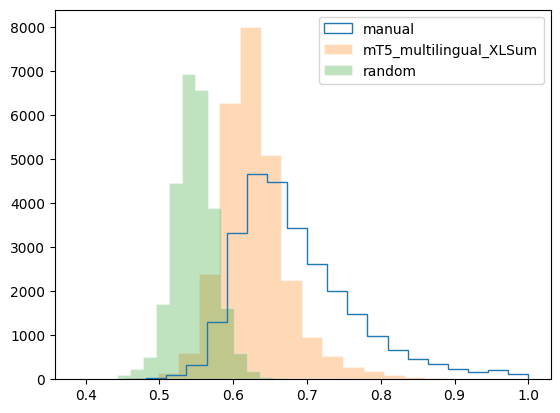

In [36]:
plt.hist(df.recall_manual, bins=20, histtype="step", label="manual")
plt.hist(df.recall_mt5, bins=20, histtype="stepfilled", label="mT5_multilingual_XLSum", alpha=0.3, edgecolor="w")
plt.hist(df.recall_random, bins=20, histtype="stepfilled", label="random", alpha=0.3, edgecolor="w")
plt.legend();

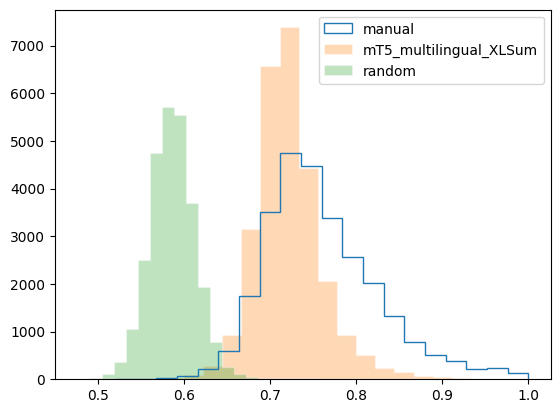

In [37]:
plt.hist(df.f1_manual, bins=20, histtype="step", label="manual")
plt.hist(df.f1_mt5, bins=20, histtype="stepfilled", label="mT5_multilingual_XLSum", alpha=0.3, edgecolor="w")
plt.hist(df.f1_random, bins=20, histtype="stepfilled", label="random", alpha=0.3, edgecolor="w")
plt.legend();

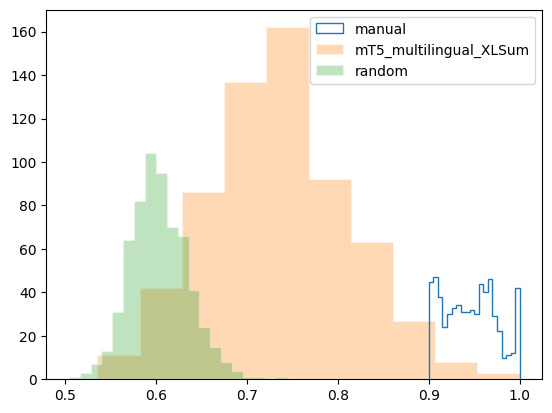

In [38]:
plt.hist(df[df.recall_manual>0.9]['recall_manual'], bins=20, histtype="step", label="manual")
plt.hist(df[df.recall_manual>0.9]['recall_mt5'], histtype="stepfilled", label="mT5_multilingual_XLSum", alpha=0.3, edgecolor="w")
plt.hist(df[df.recall_manual>0.9]['f1_random'], bins=20, histtype="stepfilled", label="random", alpha=0.3, edgecolor="w")
plt.legend();

In [39]:
df[df.recall_manual>0.9].shape[0]

631